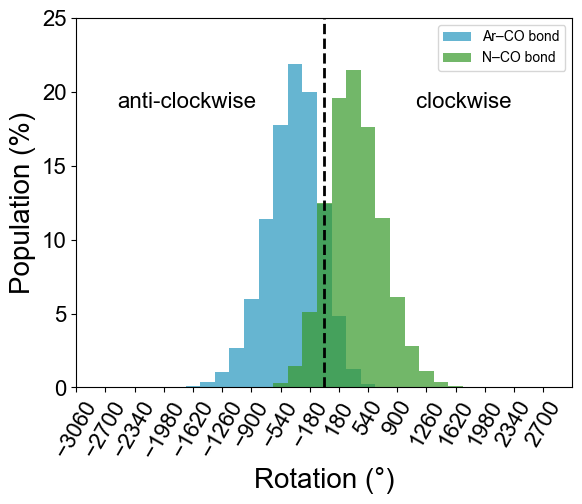

Average Ar–CO bond rotation: −381°, mean rotation per half-life: −27.5°.
Average N–CO bond rotation: +381°, mean rotation per half-life geared: +27.5°.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from math import comb, exp, factorial, log

def poisson_prob(r):
    return (exp(-log(2)) * log(2) ** r) / factorial(r)

def drop_random_poisson(arr, drop_prob):
    num_to_drop = min(int(drop_prob * len(arr)), len(arr))
    drop_indices = np.random.choice(len(arr), size=num_to_drop, replace=False)
    return np.delete(arr, drop_indices), arr[drop_indices]

def binomial_distribution_probabilities(n):
    row = np.array([comb(n - 1, k) for k in range(n)], dtype=float)
    return row / row.sum()

def generate_centered_array(n):
    return np.round((np.arange(n) - (n - 1) / 2) * 360).astype(int)

def slips_dis_calc(slips):
    integer_slips, partial_slips = int(slips), slips % 1
    probs_n = binomial_distribution_probabilities(integer_slips + 1)
    probs_n1 = binomial_distribution_probabilities(integer_slips + 2)
    dist_n = generate_centered_array(integer_slips + 1)
    dist_n1 = generate_centered_array(integer_slips + 2)
    combined_probs = {}
    for val, p in zip(dist_n, probs_n):
        combined_probs[val] = combined_probs.get(val, 0) + (1 - partial_slips) * p
    for val, p in zip(dist_n1, probs_n1):
        combined_probs[val] = combined_probs.get(val, 0) + partial_slips * p
    values = np.array(sorted(combined_probs.keys()))
    probs = np.array([combined_probs[v] for v in values])
    probs /= probs.sum()
    return values, probs

def format_rotation(value):
    sign = '−' if value < 0 else '+'
    return f"{sign}{abs(value):.3g}"

# Constants
time, half_life = 24, 1.73
oxidation_selectivity, reduction_selectivity = 0.81, 0.5
AB_conc, diol_steady_state, reaction_conc = 20.6, 9.4, 10 #mM 
aldehyde_steady_state = reaction_conc-diol_steady_state
resting_off_state = diol_steady_state/reaction_conc
r_rac, r_red = 0.0039, 0.000061*AB_conc
pop_size = 10**7
num_cycles = time / half_life
integer_cycles, partial_cycle = int(num_cycles), num_cycles % 1

# Slippage
N_CO_alde_rotation, Ar_CO_alde_rotation = 0.000002, 0.00000025
diol_Ar_CO_rotation, diol_N_CO_rotation = 0.0000005, 0.000002
slips_N_CO_alde = N_CO_alde_rotation * time * 3600 * (1-resting_off_state)
slips_Ar_CO_alde = Ar_CO_alde_rotation * time * 3600 * (1-resting_off_state)
slips_Ar_CO_diol = diol_Ar_CO_rotation * time * 3600 * resting_off_state
slips_diolN_CO = diol_N_CO_rotation * time * 3600 * resting_off_state

dis_N_CO_alde, prob_N_CO = slips_dis_calc(slips_N_CO_alde)
dis_Ar_CO_alde, prob_Ar_CO_alde = slips_dis_calc(slips_Ar_CO_alde)
dis_Ar_CO_diol, prob_Ar_CO_diol = slips_dis_calc(slips_Ar_CO_diol)
dis_diol_N_CO, prob_diol_N_CO =  slips_dis_calc(slips_diolN_CO)

# Probabilities
successful_gearing_prob = 0.999
rotation_prob = r_rac/(r_rac+r_red)
forwards_prob = reduction_selectivity * oxidation_selectivity * rotation_prob * resting_off_state
backwards_prob = (1-reduction_selectivity) * (1 - oxidation_selectivity) * rotation_prob * resting_off_state
forwards_prob_geared = reduction_selectivity * oxidation_selectivity * rotation_prob * successful_gearing_prob * resting_off_state
backwards_prob_geared = (1-reduction_selectivity) * (1 - oxidation_selectivity) * rotation_prob * successful_gearing_prob * resting_off_state
prob_per_oxidation = [backwards_prob, 1 - forwards_prob - backwards_prob, forwards_prob]
prob_per_oxidation_geared = [backwards_prob_geared, 1 - forwards_prob_geared - backwards_prob_geared, forwards_prob_geared]

# Working out rotations per half-life
pop, pop_geared = np.zeros(pop_size, dtype=int), np.zeros(pop_size, dtype=int)
popped_values, popped_values_geared = [], []
mean_samples, mean_samples_geared = [], []

for r in range(20):
    drop_prob = poisson_prob(r) * (pop_size / len(pop))
    if r > 0:
        pop += np.random.choice([180, 0, -180], size=len(pop), p=prob_per_oxidation)
    pop, popped_this_cycle = drop_random_poisson(pop, drop_prob)
    popped_values.extend(popped_this_cycle)

for r in range(20):
    drop_prob_geared = poisson_prob(r) * (pop_size / len(pop_geared))
    if r > 0:
        pop_geared += np.random.choice([-180, 0, 180], size=len(pop_geared), p=prob_per_oxidation_geared)
    pop_geared, popped_this_cycle_geared = drop_random_poisson(pop_geared, drop_prob_geared)
    popped_values_geared.extend(popped_this_cycle_geared)

# Normalize probabilities
unique_values, counts = np.unique(popped_values, return_counts=True)
normalized_probabilities = counts / counts.sum()
unique_values_geared, counts_geared = np.unique(popped_values_geared, return_counts=True)
normalized_probabilities_geared = counts_geared / counts_geared.sum()

# Full cycles
pop = np.zeros(pop_size, dtype=int)
for _ in range(integer_cycles):
    samples = np.random.choice(unique_values, size=pop_size, p=normalized_probabilities)
    pop += samples
    cycle_mean = np.mean(samples)
    mean_samples.append(cycle_mean)
overall_mean = np.mean(mean_samples)

# Partial cycle
if partial_cycle > 0:
    partial_cycle_probs = normalized_probabilities * partial_cycle
    partial_cycle_probs[unique_values == 0] = 0
    partial_cycle_probs[unique_values == 0] = 1 - partial_cycle_probs.sum()
    samples = np.random.choice(unique_values, size=pop_size, p=partial_cycle_probs)
    pop += samples

# Full cycles
pop_geared = np.zeros(pop_size, dtype=int)
for _ in range(integer_cycles):
    samples_geared = np.random.choice(unique_values_geared, size=pop_size, p=normalized_probabilities_geared)
    pop_geared += samples_geared
    cycle_mean_geared = np.mean(samples_geared)
    mean_samples_geared.append(cycle_mean_geared)
overall_mean_geared = np.mean(mean_samples_geared)

# Partial cycle
if partial_cycle > 0:
    partial_cycle_probs_geared = normalized_probabilities_geared * partial_cycle
    partial_cycle_probs_geared[unique_values_geared == 0] = 0
    partial_cycle_probs_geared[unique_values_geared == 0] = 1 - partial_cycle_probs_geared.sum()
    samples_geared = np.random.choice(unique_values_geared, size=pop_size, p=partial_cycle_probs_geared)
    pop_geared += samples_geared

# Add slips
pop += np.random.choice(dis_Ar_CO_alde, size=pop_size, p=prob_Ar_CO_alde)
pop += np.random.choice(dis_Ar_CO_diol, size=pop_size, p=prob_Ar_CO_diol)
pop_geared += np.random.choice(dis_N_CO_alde, size=pop_size, p=prob_N_CO)
pop_geared += np.random.choice(dis_diol_N_CO, size=pop_size, p=prob_diol_N_CO)

# Plot results
bin_edges = np.arange(min(pop.min(), pop_geared.min()) - 90, max(pop.max(), pop_geared.max()) + 90, 180)
plt.rcParams['font.family'] = 'Arial'
plt.hist(pop, bins=bin_edges, color="#2596be", alpha=0.7, label="Ar–CO bond")
plt.hist(pop_geared, bins=bin_edges, color='#37992a', alpha=0.7, label="N–CO bond")
plt.xlabel('Rotation (°)', fontsize=20)
plt.ylabel('Population (%)', fontsize=20)
plt.xticks(np.arange(min(pop.min(), pop_geared.min()) - 360, max(pop.max(), pop_geared.max()) + 360, 360), fontsize=16, rotation=60)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x * 100 / pop_size)}'))
plt.gca().tick_params(axis='y', labelsize=16)
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)
plt.annotate('anti-clockwise', xy=(0, 0), xytext=(min(pop.min(), pop_geared.min())/1.8, 2000000), fontsize=16, ha='center', va='top', rotation=0)
plt.annotate('clockwise ', xy=(0, 0), xytext=(max(pop.max(), pop_geared.max())*(8.5/9), 2000000), fontsize=16, ha='right', va='top', rotation=0)
plt.ylim(0,2500000)
plt.xlim(min(pop.min(), pop_geared.min(), -max(pop.max(), pop_geared.max())), max(pop.max(), pop_geared.max(), -min(pop.min(), pop_geared.min())))
plt.legend()
plt.show()
print(f"Average Ar–CO bond rotation: {format_rotation(np.mean(pop))}°, mean rotation per half-life: {format_rotation(overall_mean)}°.")
print(f"Average N–CO bond rotation: {format_rotation(np.mean(pop_geared))}°, mean rotation per half-life geared: {format_rotation(overall_mean_geared)}°.")